In [31]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as stats

# 1. Business Understanding

*Objective:*

- Validate the "Sell in May and Go Away" investment hypothesis and integrate predictive modeling to enhance investment decision-making.

*Scope:*

Seasonal Returns Analysis:

- Determine if there is a statistically significant difference in stock market returns between the May-October (summer) and November-April (winter) periods.

- Identify whether seasonal patterns exist that could be leveraged for better investment decisions.

*Predictive Modeling:*

- Utilize an ARIMA model to forecast the next day’s price for the Dow Jones Industrial Index (DJI), providing an additional tool for short-term trading and risk management.


*Strategic Implications for Investment Managers:*

- Portfolio Timing Decisions: If the hypothesis is valid, the manager could adjust the asset allocation strategy to reduce equity exposure during the summer and increase exposure during the winter. Integrating the ARIMA forecast can further enhance decision-making by providing daily insights into market movements.

- Risk Management: By reducing equity positions in underperforming periods, the manager can lower drawdowns and mitigate portfolio volatility. Daily price forecasts from the ARIMA model can signal short-term risks, enabling more proactive adjustments.

- Improved Returns: Exploiting seasonal patterns could generate higher risk-adjusted returns compared to a buy-and-hold strategy.


**Hypotheses:**

Null Hypothesis (H₀): There is no statistically significant difference in stock market returns between the May-October period and the November-April period.

Alternative Hypothesis (H₁): There is a statistically significant difference in stock market returns between the May-October period and the November-April period.








In [32]:
# Fetch data for S&P 500
start_date = "2013-01-01"
end_date = "2023-12-31"

# Fetch data directly from Yahoo Finance
data = yf.download("^DJI", start=start_date, end=end_date)

# Add Date index
data.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


# 2. Data Understanding

In [33]:
# Check data structure and missing values
data.info()
display(data.describe())

missing_values = data.isnull().sum()
print("\nMissing Values:")
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   (Date, )           2768 non-null   datetime64[ns]
 1   (Adj Close, ^DJI)  2768 non-null   float64       
 2   (Close, ^DJI)      2768 non-null   float64       
 3   (High, ^DJI)       2768 non-null   float64       
 4   (Low, ^DJI)        2768 non-null   float64       
 5   (Open, ^DJI)       2768 non-null   float64       
 6   (Volume, ^DJI)     2768 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 151.5 KB


Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,^DJI,^DJI,^DJI,^DJI,^DJI,^DJI
count,2768,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2.768000e+03
mean,2018-07-01 05:52:11.791907584,24396.074440,24396.074440,24521.704478,24255.226665,24391.399651,2.567060e+08
min,2013-01-02 00:00:00,13328.849609,13328.849609,13377.419922,13104.299805,13104.299805,3.364000e+07
25%,2015-09-30 18:00:00,17730.387695,17730.387695,17801.362793,17630.340332,17730.308105,1.123400e+08
50%,2018-06-30 12:00:00,24584.424805,24584.424805,24745.590820,24421.879883,24584.195312,2.730600e+08
75%,2021-03-31 06:00:00,31044.812988,31044.812988,31224.006836,30869.291992,31066.277832,3.432325e+08
max,2023-12-29 00:00:00,37710.101562,37710.101562,37778.851562,37650.980469,37701.628906,9.159900e+08
std,NaN,6947.221030,6947.221030,6990.489988,6902.102955,6947.059249,1.418113e+08



Missing Values:
Price      Ticker
Date                 0
Adj Close  ^DJI      0
Close      ^DJI      0
High       ^DJI      0
Low        ^DJI      0
Open       ^DJI      0
Volume     ^DJI      0
dtype: int64


#  3. Data Preparation

In [34]:
# Add a 'Month' and 'Year' column
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

In [35]:
# Calculate Monthly Returns
data['Return'] = data['Adj Close'].pct_change()

In [36]:
# Filter data for May to October (5 to 10) and November to April (11 to 4)
may_oct = data[(data['Month'] >= 5) & (data['Month'] <= 10)]
nov_apr = data[(data['Month'] <= 4) | (data['Month'] >= 11)]

In [37]:
# Drop NA
may_oct.dropna(inplace=True)
nov_apr.dropna(inplace=True)

<ipython-input-37-1c51568ce45e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  may_oct.dropna(inplace=True)
<ipython-input-37-1c51568ce45e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nov_apr.dropna(inplace=True)


In [38]:
# Descriptive Statistics
print("\nMay to October Statistics:")
print(may_oct['Return'].describe())
print("\nNovember to April Statistics:")
print(nov_apr['Return'].describe())



May to October Statistics:
count    1411.000000
mean        0.000304
std         0.008895
min        -0.068982
25%        -0.003795
50%         0.000548
75%         0.004781
max         0.039516
Name: Return, dtype: float64

November to April Statistics:
count    1356.000000
mean        0.000563
std         0.012268
min        -0.129265
25%        -0.003591
50%         0.000777
75%         0.005552
max         0.113650
Name: Return, dtype: float64


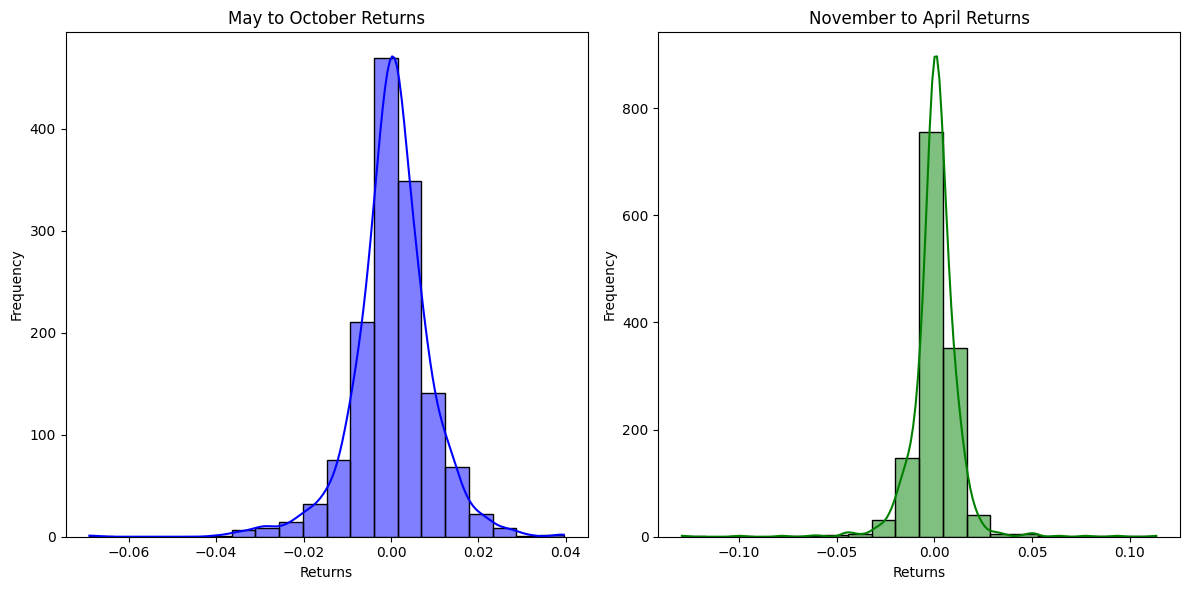

In [39]:
import seaborn as sns
# Plot Histograms for both periods
plt.figure(figsize=(12, 6))

# May to October histogram
plt.subplot(1, 2, 1)
sns.histplot(may_oct['Return'], bins=20, kde=True, color='blue', label='May-Oct')
plt.title('May to October Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')

# November to April histogram
plt.subplot(1, 2, 2)
sns.histplot(nov_apr['Return'], bins=20, kde=True, color='green', label='Nov-Apr')
plt.title('November to April Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Descriptive Statistics Analysis**

1. May to October Statistics:

- Mean (0.000276): The average return during this period is very small and close to zero, indicating that there isn’t much change in stock prices on average.
- Standard Deviation (0.010385): This value shows the level of variability in the returns. A higher standard deviation indicates more volatility, meaning there is more fluctuation in returns during this period.
- Minimum (-0.066634): The worst return during this period is a drop of about 6.67%.
- Maximum (0.047407): The best return is about 4.74%.
- Median (50% = 0.000389): The median return is very close to the mean, indicating that the distribution of returns is fairly symmetric.
- Interquartile Range (IQR): The middle 50% of returns fall between -0.004218 and 0.005373, suggesting that most returns during this period are relatively small (both positive and negative).

2. November to April Statistics:

- Mean (0.000670): The average return in this period is slightly higher than in May to October, but it is still very close to zero.
- Standard Deviation (0.011669): The variability is slightly higher than in May to October, indicating more fluctuation in returns during this period.
- Minimum (-0.119841): The worst return in this period is a drop of about 11.98%, which is worse than the worst return in May to October.
- Maximum (0.093828): The best return is a gain of about 9.38%, which is higher than the best return in May to October.
- Median (50% = 0.000826): The median return is also close to the mean, suggesting a symmetric distribution similar to May to October.
- Interquartile Range (IQR): The middle 50% of returns fall between -0.003531 and 0.005844, indicating a smaller range of returns compared to May to October.

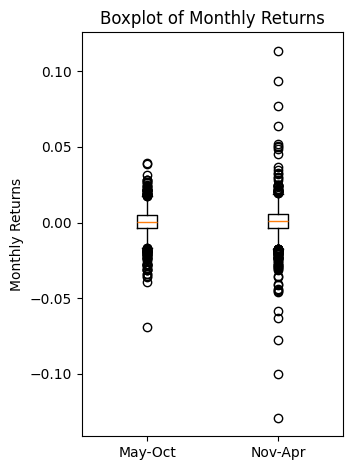

In [40]:
# Box Plot of Returns
plt.subplot(1,2,2)
plt.boxplot([may_oct['Return'], nov_apr['Return']], labels=['May-Oct', 'Nov-Apr'])
plt.title('Boxplot of Monthly Returns')
plt.ylabel('Monthly Returns')

plt.tight_layout()
plt.show()

# 4. Modelling Method

## 4.1 Normality test

In [41]:
# 1. Shapiro-Wilk test for normality
shapiro_stat_may_oct, shapiro_p_value_may_oct = stats.shapiro(may_oct['Return'])
print(f"Shapiro-Wilk Test for May-Oct Returns: Statistic = {shapiro_stat_may_oct}, p-value = {shapiro_p_value_may_oct}")

shapiro_stat_nov_apr, shapiro_p_value_nov_apr = stats.shapiro(nov_apr['Return'])
print(f"Shapiro-Wilk Test for Nov-Apr Returns: Statistic = {shapiro_stat_nov_apr}, p-value = {shapiro_p_value_nov_apr}")

if shapiro_p_value_may_oct > 0.05 and shapiro_p_value_nov_apr > 0.05:
    print("\nBoth samples appear to be normally distributed.")
else:
    print("\nAt least one sample is not normally distributed.")


Shapiro-Wilk Test for May-Oct Returns: Statistic = 0.9477593289534759, p-value = 5.774135306206393e-22
Shapiro-Wilk Test for Nov-Apr Returns: Statistic = 0.7996446549521139, p-value = 5.865365226488243e-38

At least one sample is not normally distributed.


## 4.2 Hypothesis Testing

Since the Shapiro-Wilk test results indicate that the data is not normally distributed, the t-test is not appropriate, as it assumes normality. Therefore, we should switch to non-parametric tests, which do not require the data to follow a specific distribution. In this case, we proceed with the Mann-Whitney U Test.

In [42]:
# Perform Mann-Whitney U test for comparing May-Oct and Nov-Apr returns
from scipy.stats import mannwhitneyu

# May-Oct vs Nov-Apr Mann-Whitney U Test
u_statistic, p_value_mwu = mannwhitneyu(may_oct['Return'], nov_apr['Return'], alternative='two-sided')

# Display the results
print(f"Mann-Whitney U Test Statistic: {u_statistic}")
print(f"p-value: {p_value_mwu}")

if p_value_mwu < 0.05:
    print("Reject the null hypothesis: There is a significant difference between May-Oct and Nov-Apr returns.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between May-Oct and Nov-Apr returns.")

Mann-Whitney U Test Statistic: 928814.0
p-value: 0.18504753238611726
Fail to reject the null hypothesis: There is no significant difference between May-Oct and Nov-Apr returns.


## 4.3 ARIMA Model

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from time import time
import datetime

In [44]:
# Import data
data = yf.Ticker("^DJI")
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=730)
tomorrow = end_date + datetime.timedelta(days=1)
prices = data.history(start=start_date, end=end_date).Close
prices = prices.asfreq('B')  # Business daily frequency
prices = prices.fillna(method='ffill')
prices

<ipython-input-44-6d06cdc96825>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices = prices.fillna(method='ffill')


,Close
Date,
2022-12-28 00:00:00-05:00,32875.710938
2022-12-29 00:00:00-05:00,33220.800781
2022-12-30 00:00:00-05:00,33147.250000
2023-01-02 00:00:00-05:00,33147.250000
2023-01-03 00:00:00-05:00,33136.371094
...,...
2024-12-20 00:00:00-05:00,42840.261719
2024-12-23 00:00:00-05:00,42906.949219
2024-12-24 00:00:00-05:00,43297.031250


In [45]:
# Calculate Return
returns = prices.pct_change().dropna()
returns

,Close
Date,
2022-12-29 00:00:00-05:00,0.010497
2022-12-30 00:00:00-05:00,-0.002214
2023-01-02 00:00:00-05:00,0.000000
2023-01-03 00:00:00-05:00,-0.000328
2023-01-04 00:00:00-05:00,0.004026
...,...
2024-12-20 00:00:00-05:00,0.011762
2024-12-23 00:00:00-05:00,0.001557
2024-12-24 00:00:00-05:00,0.009091


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

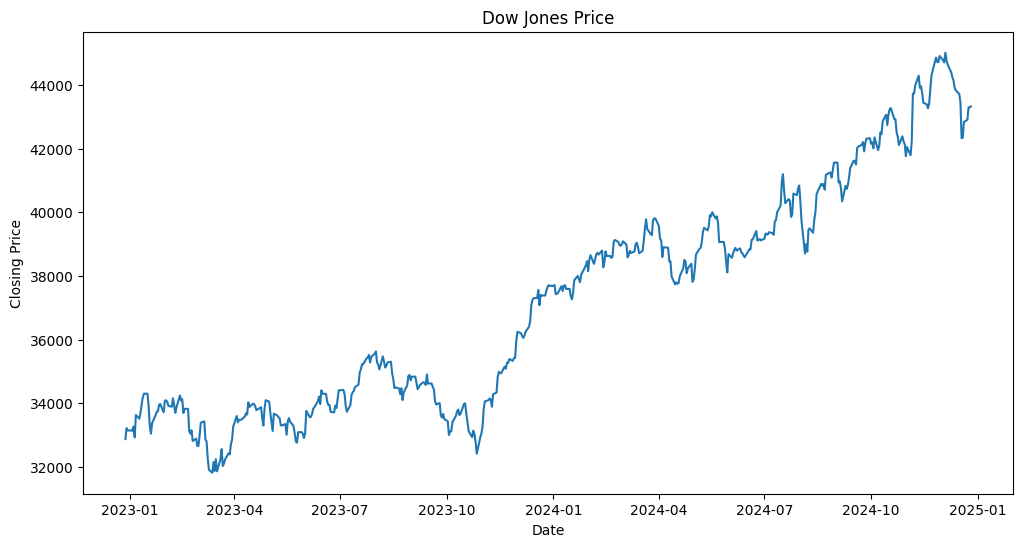

In [46]:
# Plot the Dow Jone Price
plt.figure(figsize=(12, 6))
plt.plot(prices, label='Dow Jones Price')
plt.title('Dow Jones Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt

ARIMA models assume that the time series is stable over time. If the data contains trends, seasonality, or varying variance, the model may have difficulty detecting significant patterns. Therefore, it is essential to perform a stationarity test before applying the ARIMA model.

In [47]:
# Check for Stationary
from statsmodels.tsa.stattools import adfuller
adf = adfuller(prices)
print(f"ADF Statistic: {adf[0]}")
print(f"p-value: {adf[1]}")

if adf[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -0.4266882489536564
p-value: 0.9055465289998237
The time series is not stationary.



Since the Dow Jones price shows a clear trend, as indicated by the chart, the data is non-stationary, which is further confirmed by the ADF test results. To address this, we should apply differencing to make the series stationary.

In [48]:
# Differencing
prices_diff = prices.diff().dropna()
prices_diff

,Close
Date,
2022-12-29 00:00:00-05:00,345.089844
2022-12-30 00:00:00-05:00,-73.550781
2023-01-02 00:00:00-05:00,0.000000
2023-01-03 00:00:00-05:00,-10.878906
2023-01-04 00:00:00-05:00,133.398438
...,...
2024-12-20 00:00:00-05:00,498.023438
2024-12-23 00:00:00-05:00,66.687500
2024-12-24 00:00:00-05:00,390.082031


In [49]:
# Stationary check again to make sure the seires is stationary
adf = adfuller(prices_diff)
print(f"ADF Statistic: {adf[0]}")
print(f"p-value: {adf[1]}")

if adf[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -21.124254839157974
p-value: 0.0
The time series is stationary.


ACF and PACF plots are essential for visualizing autocorrelation patterns in the data, helping identify the appropriate parameters for the ARIMA model, and ensuring that the series is properly modeled for accurate forecasting.

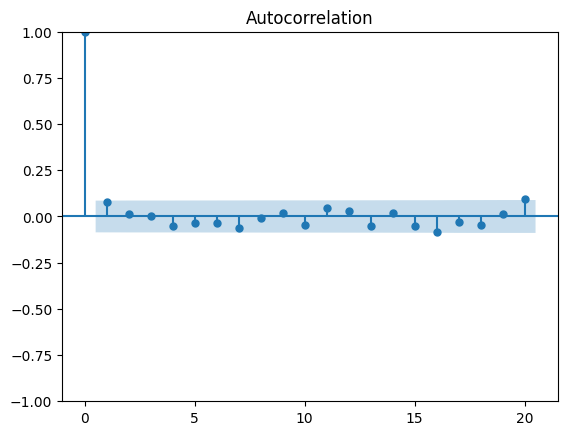

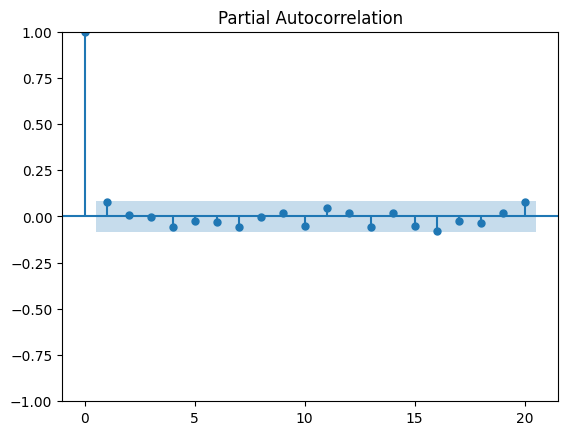

In [50]:
# Plot ACF and PACF
plot_acf(prices_diff, lags=20)
plt.show()

plot_pacf(prices_diff, lags=20)
plt.show()

In [51]:
# Build ARIMA model
train_size = int(len(prices) * 0.8)
train, test = prices[:train_size], prices[train_size:]

While the plots suggested that both p and q should be 20, the resulting model appeared to perform poorly. As a result, I decided to use auto_arima, which systematically selects the best parameters based on model selection criteria, ensuring a more accurate and reliable model for forecasting.

In [52]:
!pip install pmdarima
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [53]:
# Fit Auto ARIMA model on training data
auto_model = pm.auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True, trace=True, error_action="ignore", max_order=None)

# Print the selected order
print("Optimal ARIMA order:", auto_model.order)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5744.600, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5739.943, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5739.658, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5739.466, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5740.292, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5741.070, Time=1.20 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5740.851, Time=0.42 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5742.685, Time=2.12 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5739.395, Time=0.23 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5741.101, Time=0.33 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5740.991, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5739.597, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5742.800, Time=0.93 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.343 seconds
Optimal ARIMA order: (0, 1, 1)


In [54]:
# Make predictions
predictions = []
history = list(train)

# Forecast for each point in the test set
for t in range(len(test)):
    # Fit model and predict next point
    model = pm.ARIMA(order=auto_model.order)
    model_fit = model.fit(history)

    # Forecast
    output = model_fit.predict(n_periods=1)
    yhat = output[0]

    # Store prediction
    predictions.append(yhat)

    # Add actual observation to history for next prediction
    history.append(test.iloc[t])


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

# 5. Evaluation

In [55]:
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mse)

# Print performance metrics
print('\nPerformance Metrics:')
print('Mean Squared Error: ', mse)
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)


Performance Metrics:
Mean Squared Error:  113635.36514411833
Mean Absolute Error:  248.42192285035617
Root Mean Squared Error:  337.0984502250319


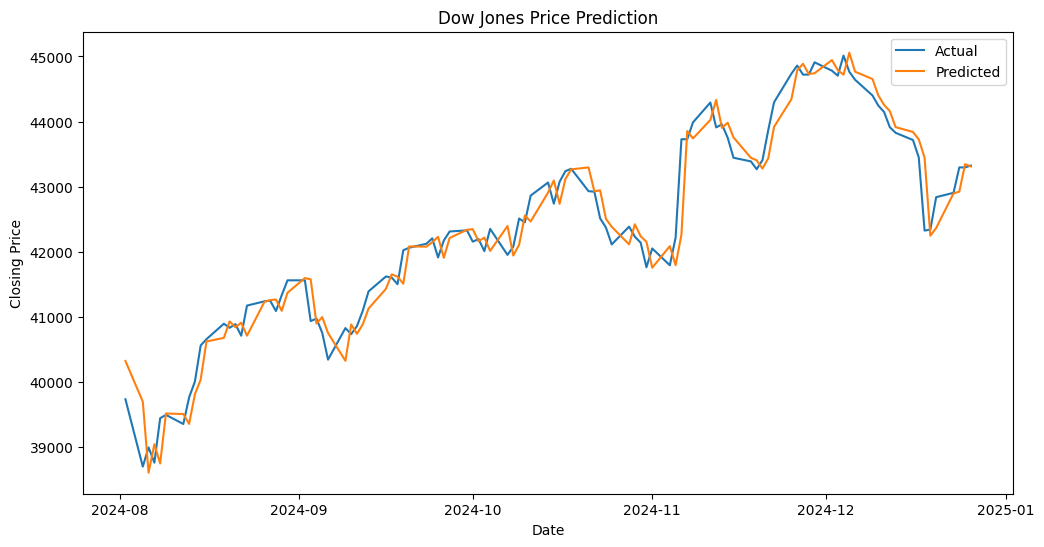

In [56]:
# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.title('Dow Jones Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [57]:
# Print model summary
print("\nModel Summary:")
print(auto_model.summary())


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  417
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2867.698
Date:                Fri, 27 Dec 2024   AIC                           5739.395
Time:                        20:55:59   BIC                           5747.457
Sample:                    12-28-2022   HQIC                          5742.583
                         - 08-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0816      0.050      1.644      0.100      -0.016       0.179
sigma2      5.733e+04   3680.380     15.577      0.000    5.01e+04    6.45e+04
Ljung-Box (L1) (Q):                 

In [58]:
# Next Day Forecast
# Use entire dataset for final model
full_model = pm.ARIMA(order=auto_model.order)
full_model_fit = full_model.fit(prices)

# Forecast next day's price
next_day_forecast = full_model_fit.predict(n_periods=1)

# Calculate prediction interval (confidence interval)
prediction_interval = full_model_fit.predict(n_periods=1, return_conf_int=True)
lower_bound = prediction_interval[1][0][0]
upper_bound = prediction_interval[1][0][1]

print("\nNext Day Forecast:", next_day_forecast)
print("\nPrediction Interval:", prediction_interval)
print("\nLower Bound:", lower_bound)
print("\nUpper Bound:", upper_bound)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Next Day Forecast: 2024-12-27 00:00:00-05:00    43345.323243
Freq: B, dtype: float64

Prediction Interval: (2024-12-27 00:00:00-05:00    43345.323243
Freq: B, dtype: float64, array([[42832.63376329, 43858.01272245]]))

Lower Bound: 42832.63376328915

Upper Bound: 43858.01272244638


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [59]:
# print prediction
display(predictions)

[40324.99669497037,
 39700.64134367425,
 38609.04222665236,
 39047.13337615304,
 38750.44981785573,
 39518.06120618019,
 39510.64247444541,
 39358.74279134212,
 39813.23444077171,
 40039.77562923325,
 40624.41039867022,
 40679.28307737973,
 40932.30875136609,
 40843.40785690714,
 40912.136923918064,
 40713.01408105193,
 41231.2781658278,
 41259.663835330815,
 41268.125003475834,
 41094.842361968986,
 41372.98109403925,
 41597.689138295056,
 41579.15712840673,
 40900.76627476535,
 40998.467462877124,
 40753.20907890233,
 40327.08634151709,
 40885.11368175074,
 40742.03198257586,
 40887.72701683432,
 41130.17815663249,
 41432.33166506296,
 41654.920281341685,
 41620.13241919998,
 41511.39603594412,
 42083.33278931283,
 42080.49736366441,
 42147.51747854682,
 42231.80244056166,
 41908.85411789766,
 42213.3735491542,
 42339.39640266039,
 42348.470583479255,
 42162.08389311112,
 42218.50396068516,
 42015.33329589433,
 42397.05398644164,
 41943.6597686711,
 42108.28048915662,
 42558.93513411